In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

%config InlineBackend.figure_format = 'retina'

In [240]:
sample_size = 1000

# 1. Variable Creation
#### 1.1 Categoricals
* `size`: This will be correlated with price. It will not be correlated with color.
* `color`: This will not be correlated with price or size. 
* `container`: The container used to ship item. This will be correlated with size (a larger item will need a larger container).

In [241]:
size = np.array([
    ['XS'] * int(sample_size / 5),
    ['S'] * int(sample_size / 5),
    ['M'] * int(sample_size / 5),
    ['L'] * int(sample_size / 5),
    ['XL'] * int(sample_size / 5),
]).flatten()

np.unique(size, return_counts=True)

(array(['L', 'M', 'S', 'XL', 'XS'], dtype='<U2'),
 array([200, 200, 200, 200, 200]))

In [242]:
container_map = {
    'XS': lambda x: np.random.choice(['envelope', 'bag', 'box'], p=[0.8, 0.15, 0.05]),
    'S': lambda x: np.random.choice(['envelope', 'bag', 'box'], p=[0.5, 0.4, 0.1]),
    'M': lambda x: np.random.choice(['envelope', 'bag', 'box'], p=[0.4, 0.4, 0.2]),
    'L': lambda x: np.random.choice(['envelope', 'bag', 'box'], p=[0.2, 0.4, 0.4]),
    'XL': lambda x: np.random.choice(['envelope', 'bag', 'box'], p=[0.05, 0.2, 0.75])
}

container = []
for val in size:
    container.append(container_map[val](None))
    
container = np.array(container)

In [243]:
age_groups_list = ['toddler', 'child', 'teen', 'adult', 'parent']
age_group_map = {
    'XS': lambda x: np.random.choice(age_groups_list, p=[0.8, 0.16, 0.02, 0.01, 0.01]),
    'S': lambda x: np.random.choice(age_groups_list, p=[0.1, 0.8, 0.05, 0.03, 0.02]),
    'M': lambda x: np.random.choice(age_groups_list, p=[0.01, 0.1, 0.8, 0.08, 0.01]),
    'L': lambda x: np.random.choice(age_groups_list, p=[0.01, 0.03, 0.1, 0.8, 0.06]),
    'XL': lambda x: np.random.choice(age_groups_list, p=[0.01, 0.01, 0.03, 0.15, 0.8])
}

age_groups = []
for val in size:
    age_groups.append(age_group_map[val](None))
    
age_groups = np.array(age_groups)

In [244]:
color = np.random.choice(['blue', 'green', 'red', 'orange'], sample_size)
np.unique(color, return_counts=True)

(array(['blue', 'green', 'orange', 'red'], dtype='<U6'),
 array([247, 270, 247, 236]))

#### 1.2 Continuous
* `price`: This will have mutual information with `size`, no mutual information with `weight` 
* `weight`: This will not have mutual information with anything.
* `tax`: This will have mutual information with `price`

In [245]:
price_map = {
    'XS': lambda x: np.random.uniform(low=10, high=21),
    'S': lambda x: np.random.uniform(low=20, high=31),
    'M': lambda x: np.random.uniform(low=30, high=41),
    'L': lambda x: np.random.uniform(low=40, high=51),
    'XL': lambda x: np.random.uniform(low=50, high=60)
}

price = []
for val in size:
    price.append(price_map[val](None))
    
price = np.array(price)

In [246]:
tax = price * 0.08 + np.random.random(size=price.shape[0]) * 0.5

In [247]:
weight = np.random.random(size=sample_size) * 50

Text(0.5, 0, 'weight')

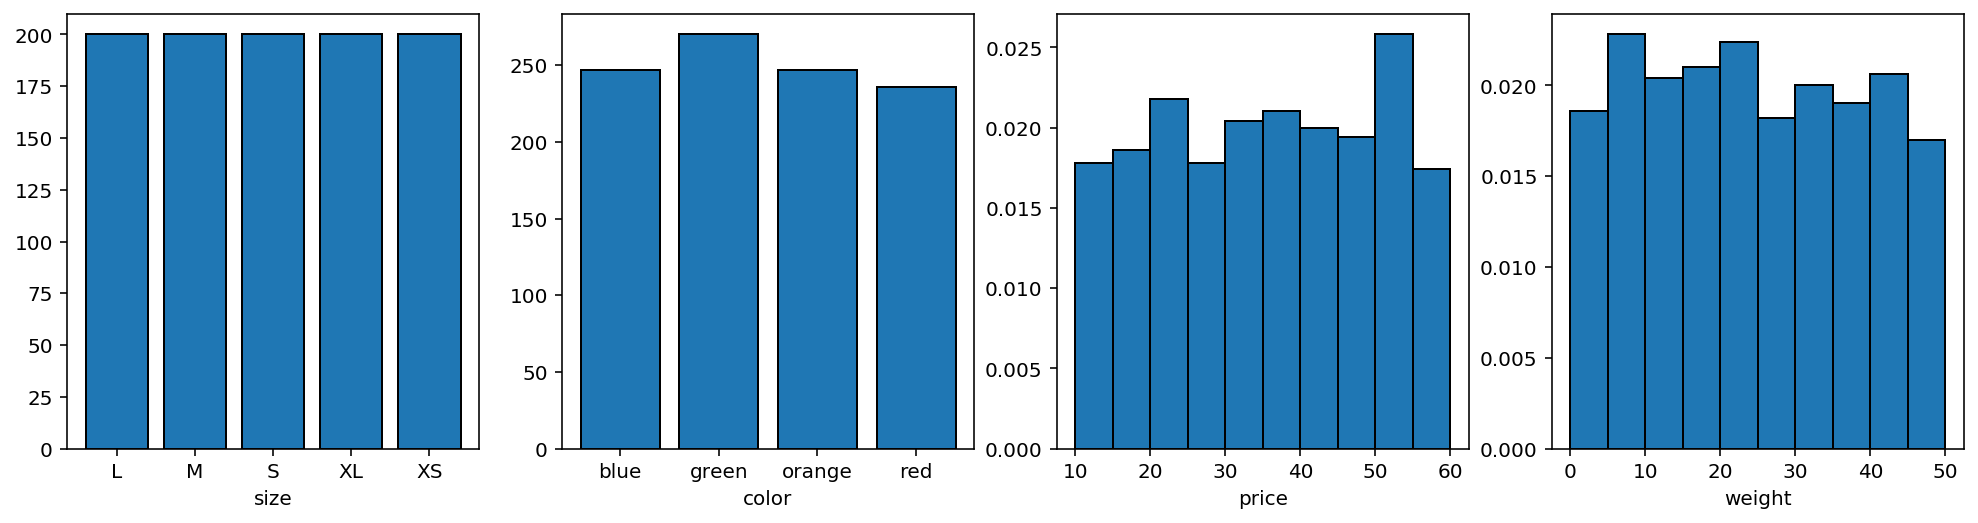

In [248]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(17,4))

size_idx, size_count = np.unique(size, return_counts=True)
ax[0].bar(size_idx, height=size_count, edgecolor='black')
ax[0].set_xlabel('size')

color_idx, color_count = np.unique(color, return_counts=True)
ax[1].bar(color_idx, height=color_count, edgecolor='black')
ax[1].set_xlabel('color')

ax[2].hist(price, edgecolor='black',  density=True)
ax[2].set_xlabel('price')

ax[3].hist(weight, edgecolor='black', density=True)
ax[3].set_xlabel('weight')


## 2. Categorical vs. Continous
Compare size and price (should be high mutual information).

In [249]:
def create_categorical_masks(X):
    masks = {}
    for x in np.unique(X):
        masks[x] = X == x
    return masks

In [250]:
def cat_cont_mut_inf(X1, X2):
    """X1 -> categorical, X2 -> continuous"""
    
    cat_masks = create_categorical_masks(X1)
    
    X2_subsets = {x2: X2[mask] for x2, mask in cat_masks.items()}
    
    ks_results = {}
    for x1_i, x2_i in X2_subsets.items():
        for x1_j, x2_j in X2_subsets.items():
            if x1_i != x1_j:
                ks_results[(x1_i, x1_j)] = ks_2samp(x2_i, x2_j).statistic

    return ks_results

#### 2.1 `Size` vs. `Price`

In [251]:
np.array(list(cat_cont_mut_inf(size, price).values())).mean()

0.974

#### 2.2 `Color` vs. `Price`

In [252]:
np.array(list(cat_cont_mut_inf(color, price).values())).mean()

0.06568116413492565

## 3. Continuous vs. Continuous

In [253]:
def bin_even_width(X, num_bins=10):
    X_hist = np.histogram(X, bins=num_bins)
    bins = set()
    for idx in range(len(X_hist[1]) - 1):
        bins.add((X_hist[1][idx], X_hist[1][idx + 1]))
    return bins
    
def bin_even_count(X, num_bins=10):
    X_sorted = np.sort(X)
    X_len = len(X_sorted)
    bin_size = int(X_len / num_bins)
    bins = set()
    for i in range(num_bins):
        bin_lower = X_sorted[i * bin_size] 
        bin_upper = X_sorted[(i + 1) * bin_size - 1] 
        bins.add((bin_lower, bin_upper))
    return bins

In [254]:
def create_continuous_masks(X, bins):
    masks = {}
    for bin_x in bins:
        masks[bin_x] = (X >= bin_x[0]) & (X <= bin_x[1]) 
    return masks


def cont_cont_mut_inf(X1, X2, bin_func=bin_even_width, **kwargs):
    """X1 -> continuous, X2 -> continuous"""
    
    bins = bin_func(X1, **kwargs)

    cont_masks = create_continuous_masks(X1, bins)
    
    X2_subsets = {x2: X2[mask] for x2, mask in cont_masks.items()}
    
    ks_results = {}
    for x1_i, x2_i in X2_subsets.items():
        for x1_j, x2_j in X2_subsets.items():
            if x1_i != x1_j:
                ks_results[(x1_i, x1_j)] = ks_2samp(x2_i, x2_j).statistic

    return ks_results

#### 3.1 `weight` vs `price`

In [255]:
price_v_weight = cont_cont_mut_inf(price, weight, num_bins=10)
np.array(list(price_v_weight.values())).mean()

0.1055648803621868

In [256]:
price_v_weight = cont_cont_mut_inf(price, weight, bin_func=bin_even_count, num_bins=10)
np.array(list(price_v_weight.values())).mean()

0.12355555555555554

In [257]:
weight_v_price = cont_cont_mut_inf(weight, price, num_bins=10)
np.array(list(weight_v_price.values())).mean()

0.11981016161360793

In [258]:
weight_v_price = cont_cont_mut_inf(weight, price, bin_func=bin_even_count, num_bins=10)
np.array(list(weight_v_price.values())).mean()

0.11422222222222225

#### 3.2 `price` vs. `tax`

In [259]:
price_v_tax = cat_cont_mut_inf(price, tax, num_bins=10)
np.array(list(price_v_tax.values())).mean()

0.9374256955484737

In [260]:
tax_v_price = cat_cont_mut_inf(tax, price, num_bins=10)
np.array(list(tax_v_price.values())).mean()

0.9426827078459635

## 4. Categorical vs. Categorical

In [261]:
def cat_cat_mut_inf(X1, X2):
    """X1 -> categorical, X2 -> categorical"""
    
    cat_masks = create_categorical_masks(X1)
    
    X2_subsets = {x2: X2[mask] for x2, mask in cat_masks.items()}
    
    ks_results = {}
    for x1_i, x2_i in X2_subsets.items():
        for x1_j, x2_j in X2_subsets.items():
            if x1_i != x1_j:
                ks_results[(x1_i, x1_j)] = ks_2samp(x2_i, x2_j).statistic

    return ks_results

#### 4.1 Color vs size

In [262]:
color_v_size = cat_cat_mut_inf(color, size)
np.array(list(color_v_size.values())).mean()

0.032226411433964215

In [263]:
size_v_color = cat_cat_mut_inf(size, color)
np.array(list(size_v_color.values())).mean()

0.03500000000000001

#### 4.2 Size vs container

In [264]:
size_v_container = cat_cat_mut_inf(size, container)
np.array(list(size_v_container.values())).mean()

0.37299999999999994

In [265]:
container_v_size = cat_cat_mut_inf(container, size)
np.array(list(container_v_size.values())).mean()

0.3209653645706998

#### Explore size vs container

In [266]:
container_masks = create_categorical_masks(container)

In [267]:
size_subsets = {x2: size[mask] for x2, mask in container_masks.items()}

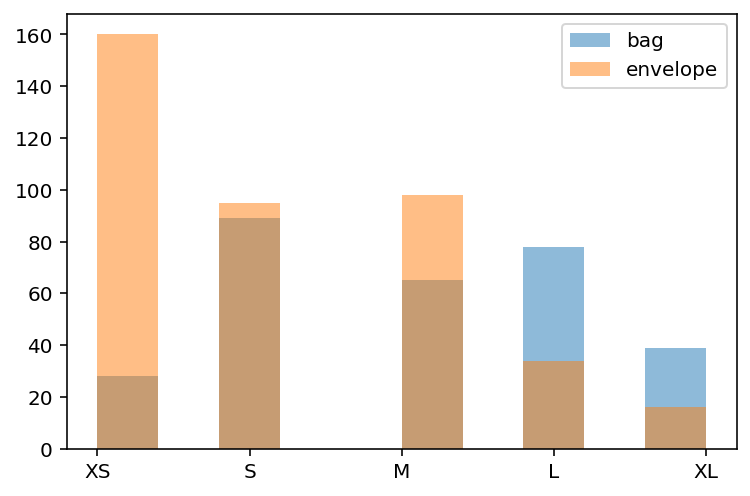

In [268]:
plt.hist(size_subsets['bag'], alpha=0.5)
plt.hist(size_subsets['envelope'], alpha=0.5)
plt.legend(['bag', 'envelope'])

In [269]:
container_v_size

{('bag', 'box'): 0.3027653700253642,
 ('bag', 'envelope'): 0.3033768475563707,
 ('box', 'bag'): 0.3027653700253642,
 ('box', 'envelope'): 0.3567538761303645,
 ('envelope', 'bag'): 0.3033768475563707,
 ('envelope', 'box'): 0.3567538761303645}

In [270]:
ks_2samp(size_subsets['bag'], size_subsets['envelope'])

Ks_2sampResult(statistic=0.3033768475563707, pvalue=1.7763568394002505e-14)

In [271]:
sub_set_for_bag = pd.Series(size_subsets['bag']).value_counts() / len(size_subsets['bag']) 
sub_set_for_bag

S     0.297659
L     0.260870
M     0.217391
XL    0.130435
XS    0.093645
dtype: float64

In [272]:
sub_set_for_envelope = pd.Series(size_subsets['envelope']).value_counts() / len(size_subsets['envelope'])
sub_set_for_envelope

XS    0.397022
M     0.243176
S     0.235732
L     0.084367
XL    0.039702
dtype: float64

In [273]:
np.abs(sub_set_for_bag - sub_set_for_envelope)

L     0.176502
M     0.025785
S     0.061927
XL    0.090733
XS    0.303377
dtype: float64

#### 4.3 Age group vs size

In [275]:
agegroup_v_size = cat_cat_mut_inf(age_groups, size)
np.array(list(agegroup_v_size.values())).mean()

0.785976063886026

In [276]:
size_v_agegroup = cat_cat_mut_inf(size, age_groups)
np.array(list(size_v_agegroup.values())).mean()

0.7489999999999999

In [277]:
size_v_agegroup

{('L', 'M'): 0.74,
 ('L', 'S'): 0.81,
 ('L', 'XL'): 0.695,
 ('L', 'XS'): 0.825,
 ('M', 'L'): 0.74,
 ('M', 'S'): 0.655,
 ('M', 'XL'): 0.745,
 ('M', 'XS'): 0.825,
 ('S', 'L'): 0.81,
 ('S', 'M'): 0.655,
 ('S', 'XL'): 0.65,
 ('S', 'XS'): 0.73,
 ('XL', 'L'): 0.695,
 ('XL', 'M'): 0.745,
 ('XL', 'S'): 0.65,
 ('XL', 'XS'): 0.815,
 ('XS', 'L'): 0.825,
 ('XS', 'M'): 0.825,
 ('XS', 'S'): 0.73,
 ('XS', 'XL'): 0.815}

In [278]:
age_group_masks = create_categorical_masks(age_groups)

In [279]:
size_subsets = {x2: size[mask] for x2, mask in age_group_masks.items()}

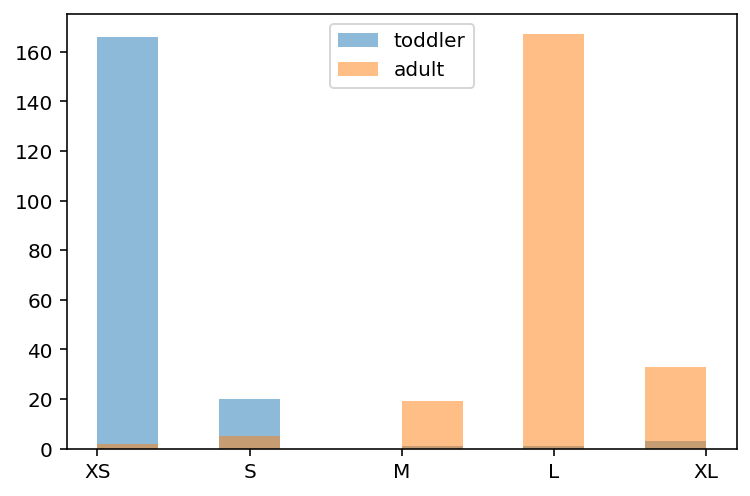

In [280]:
plt.hist(size_subsets['toddler'], alpha=0.5)
plt.hist(size_subsets['adult'], alpha=0.5)
plt.legend(['toddler', 'adult'])

### Going to want to consider how to handle this going forward. 
* On one hand, it seems like the relationship should be a bit stronger (there is more mutual information than is being let on here)
* On the other, it is clearly fair to say that knowing container does not, by any means, give you the size. So this is probably pretty fair
* Should the p value be included???

# New Idea - Use KL Divergence in place of KS-test?
* May want to consider using KL-divergence as a metric since that is more in line with the information theoretic approach (compared to using KS-statistic as our metric)
* Note that if we swapped in KL divergence in place of the KS test, it's role would be _different_ compared to that of it's role in mutual information! In mutual information, the two distributions that are being compared are the joint $p(x, y)$ and the joint if $x$ and $y$ are independent, $p(x)p(y)$. Hence, in the case of mutual information, a high KL divergence corresponds to high mutual information-this is because $p(x, y)$  is very different from $p(x)p(y)$ and hence $x$ and $y$ share information/are not independent. On the other hand, in our new case we are comparing $p(x \mid y = y_i)$ and $p(x \mid y = y_j)$, currently via the KS-statistic. If we swap in the KL divergence, then a high KL divergence will again correspond to high mutual information! On one hand it will mean that the distributions of $p(x \mid y = y_i)$ and $p(x \mid y = y_j)$ are dissimilar. However, that really means that conditioning on different values of $y$ will lead to different conditional distributions of $x$. This is another way in which it is clear that $x$ and $y$ have mutual information, we can define independence if $p(x) = p(x \mid y)$.
* An example of the above is illustrated below:

In [281]:
from scipy.special import kl_div
import sklearn
from math import log2

def kl_divergence(p, q):
    return sum(p[i] * log2(p[i]/q[i]) for i in range(len(p)))

def normalize_kl(kl_div_val):
    return 1 - np.exp(-kl_div_val)

In [295]:
p = np.unique(size_subsets['adult'], return_counts=True)[1] / size_subsets['adult'].shape[0]
print(f'Distribution of size, conditional on adult: ', p)

Distribution of size, conditional on adult:  [0.73893805 0.0840708  0.02212389 0.1460177  0.00884956]


In [283]:
q = np.unique(size_subsets['toddler'], return_counts=True)[1] / size_subsets['toddler'].shape[0]
print(f'Distribution of size, conditional on toddler: ', q)

Distribution of size, conditional on toddler:  [0.0052356  0.0052356  0.10471204 0.01570681 0.86910995]


In [284]:
kl_div_adult_toddler = kl_divergence(p, q)
kl_div_adult_toddler

5.974950768943268

In [285]:
kl_div_adult_toddler_normalized = normalize_kl(kl_div_adult_toddler)
print('Normalized KL Divergence: ', kl_div_adult_toddler_normalized)

Normalized KL Divergence:  0.9974583727893177


Other idea, could be nice to allow for mutual information function to accept the KS-test, KL-divergence, etc, as it's metric of choice!

In [286]:
q = np.unique(size_subsets['parent'], return_counts=True)[1] / size_subsets['parent'].shape[0]
print(f'Distribution of size, conditional on parent: ', q)

Distribution of size, conditional on parent:  [0.03409091 0.02840909 0.03977273 0.88068182 0.01704545]


In [287]:
q

array([0.03409091, 0.02840909, 0.03977273, 0.88068182, 0.01704545])

In [288]:
kl_div_adult_parent = kl_divergence(p, q)
kl_div_adult_parent

3.005357565968958

In [289]:
kl_div_adult_parent_normalized = normalize_kl(kl_div_adult_parent)
print('Normalized KL Divergence: ', kl_div_adult_parent_normalized)

Normalized KL Divergence:  0.9504789558777763


Let's see how $p(x \mid y)$ compares with simply $p(x)$

In [299]:
q = np.unique(size, return_counts=True)[1] / size.shape[0]
print(f'Distribution of size, marginal: ', q)

Distribution of size, marginal:  [0.2 0.2 0.2 0.2 0.2]


In [297]:
kl_div_adult_overall = kl_divergence(p, q)
kl_div_adult_overall

1.111766327214921

In [298]:
normalize_kl(kl_div_adult_overall)

0.6710226340917829

In [237]:
# Iterate over all subsets
p = np.unique(size_subsets['adult'], return_counts=True)[1] / size_subsets['adult'].shape[0]

In [238]:
for age_group in size_subsets.keys():
    p = np.unique(size_subsets[age_group], return_counts=True)[1] / size_subsets[age_group].shape[0]
    kl_div = kl_divergence(p, q)
    print(f'KL Divergence between {age_group} and overall: ', kl_div)
    print(f'Normalized KL Divergence between {age_group} and overall: ', normalize_kl(kl_div))

KL Divergence between adult and overall:  1.0767654884262103
Normalized KL Divergence between adult and overall:  0.6593042703448532
KL Divergence between child and overall:  1.2361081920766084
Normalized KL Divergence between child and overall:  0.7094873598917726
KL Divergence between parent and overall:  1.6454889754783197
Normalized KL Divergence between parent and overall:  0.8070817925458484
KL Divergence between teen and overall:  1.2689106580392024
Normalized KL Divergence between teen and overall:  0.7188622898649216
KL Divergence between toddler and overall:  1.7005468249773648
Normalized KL Divergence between toddler and overall:  0.8174163445533578


The issue above is that I was not accounting for how likely we were to an adult in the first place! Let's run again, this time accounting for that:

In [313]:
kl_div_adult_overall = kl_divergence(p, q)
p_adult = (pd.Series(age_groups).value_counts() / len(age_groups))['adult']
kl_div_adult_overall * p_adult

0.25125918995057217

Now run on entire sequence:

In [319]:
kl_divs = {}
for age_group in size_subsets.keys():
    p = np.unique(size_subsets[age_group], return_counts=True)[1] / size_subsets[age_group].shape[0]
    kl_div = kl_divergence(p, q)
    print(f'KL Divergence between {age_group} and overall: ', kl_div)
    kl_divs[age_group] = kl_div
#     print(f'Normalized KL Divergence between {age_group} and overall: ', normalize_kl(kl_div))

KL Divergence between adult and overall:  1.111766327214921
KL Divergence between child and overall:  1.2097655070104567
KL Divergence between parent and overall:  1.5632071026866405
KL Divergence between teen and overall:  1.1846376606764957
KL Divergence between toddler and overall:  1.6316720155610391


In [320]:
kl_divs

{'adult': 1.111766327214921,
 'child': 1.2097655070104567,
 'parent': 1.5632071026866405,
 'teen': 1.1846376606764957,
 'toddler': 1.6316720155610391}

In [327]:
# To get mutual information, factor in the probability of being in specific age group
p_age_group = dict(pd.Series(age_groups).value_counts() / len(age_groups))

mi_s = []
for age_group, kl_div in kl_divs.items():
    
    mi_s.append(kl_div * p_age_group[age_group])

In [329]:
sum(mi_s)

1.325331731389375

In [341]:
normalize_kl(sum(mi_s))

0.7342852014723708

### Run test, see how close my function is to the entropy estimators library!

In [342]:
import warnings

import numpy as np
import numpy.linalg as la
from numpy import log
from scipy.special import digamma
from sklearn.neighbors import BallTree, KDTree

# CONTINUOUS ESTIMATORS


def entropy(x, k=3, base=2):
    """ The classic K-L k-nearest neighbor continuous entropy estimator
        x should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
        if x is a one-dimensional scalar and we have four samples
    """
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    x = np.asarray(x)
    n_elements, n_features = x.shape
    x = add_noise(x)
    tree = build_tree(x)
    nn = query_neighbors(tree, x, k)
    const = digamma(n_elements) - digamma(k) + n_features * log(2)
    return (const + n_features * np.log(nn).mean()) / log(base)


def centropy(x, y, k=3, base=2):
    """ The classic K-L k-nearest neighbor continuous entropy estimator for the
        entropy of X conditioned on Y.
    """
    xy = np.c_[x, y]
    entropy_union_xy = entropy(xy, k=k, base=base)
    entropy_y = entropy(y, k=k, base=base)
    return entropy_union_xy - entropy_y


def tc(xs, k=3, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    entropy_features = [entropy(col, k=k, base=base) for col in xs_columns]
    return np.sum(entropy_features) - entropy(xs, k, base)


def ctc(xs, y, k=3, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    centropy_features = [centropy(col, y, k=k, base=base)
                         for col in xs_columns]
    return np.sum(centropy_features) - centropy(xs, y, k, base)


def corex(xs, ys, k=3, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    cmi_features = [mi(col, ys, k=k, base=base) for col in xs_columns]
    return np.sum(cmi_features) - mi(xs, ys, k=k, base=base)


def mi(x, y, z=None, k=3, base=2, alpha=0):
    """ Mutual information of x and y (conditioned on z if z is not None)
        x, y should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
        if x is a one-dimensional scalar and we have four samples
    """
    assert len(x) == len(y), "Arrays should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    x, y = np.asarray(x), np.asarray(y)
    x, y = x.reshape(x.shape[0], -1), y.reshape(y.shape[0], -1)
    x = add_noise(x)
    y = add_noise(y)
    points = [x, y]
    if z is not None:
        z = np.asarray(z)
        z = z.reshape(z.shape[0], -1)
        points.append(z)
    points = np.hstack(points)
    # Find nearest neighbors in joint space, p=inf means max-norm
    tree = build_tree(points)
    dvec = query_neighbors(tree, points, k)
    if z is None:
        a, b, c, d = avgdigamma(x, dvec), avgdigamma(
            y, dvec), digamma(k), digamma(len(x))
        if alpha > 0:
            d += lnc_correction(tree, points, k, alpha)
    else:
        xz = np.c_[x, z]
        yz = np.c_[y, z]
        a, b, c, d = avgdigamma(xz, dvec), avgdigamma(
            yz, dvec), avgdigamma(z, dvec), digamma(k)
    return (-a - b + c + d) / log(base)


def cmi(x, y, z, k=3, base=2):
    """ Mutual information of x and y, conditioned on z
        Legacy function. Use mi(x, y, z) directly.
    """
    return mi(x, y, z=z, k=k, base=base)


def kldiv(x, xp, k=3, base=2):
    """ KL Divergence between p and q for x~p(x), xp~q(x)
        x, xp should be a list of vectors, e.g. x = [[1.3], [3.7], [5.1], [2.4]]
        if x is a one-dimensional scalar and we have four samples
    """
    assert k < min(len(x), len(xp)), "Set k smaller than num. samples - 1"
    assert len(x[0]) == len(xp[0]), "Two distributions must have same dim."
    x, xp = np.asarray(x), np.asarray(xp)
    x, xp = x.reshape(x.shape[0], -1), xp.reshape(xp.shape[0], -1)
    d = len(x[0])
    n = len(x)
    m = len(xp)
    const = log(m) - log(n - 1)
    tree = build_tree(x)
    treep = build_tree(xp)
    nn = query_neighbors(tree, x, k)
    nnp = query_neighbors(treep, x, k - 1)
    return (const + d * (np.log(nnp).mean() - np.log(nn).mean())) / log(base)


def lnc_correction(tree, points, k, alpha):
    e = 0
    n_sample = points.shape[0]
    for point in points:
        # Find k-nearest neighbors in joint space, p=inf means max norm
        knn = tree.query(point[None, :], k=k+1, return_distance=False)[0]
        knn_points = points[knn]
        # Substract mean of k-nearest neighbor points
        knn_points = knn_points - knn_points[0]
        # Calculate covariance matrix of k-nearest neighbor points, obtain eigen vectors
        covr = knn_points.T @ knn_points / k
        _, v = la.eig(covr)
        # Calculate PCA-bounding box using eigen vectors
        V_rect = np.log(np.abs(knn_points @ v).max(axis=0)).sum()
        # Calculate the volume of original box
        log_knn_dist = np.log(np.abs(knn_points).max(axis=0)).sum()

        # Perform local non-uniformity checking and update correction term
        if V_rect < log_knn_dist + np.log(alpha):
            e += (log_knn_dist - V_rect) / n_sample
    return e


# DISCRETE ESTIMATORS
def entropyd(sx, base=2):
    """ Discrete entropy estimator
        sx is a list of samples
    """
    unique, count = np.unique(sx, return_counts=True, axis=0)
    # Convert to float as otherwise integer division results in all 0 for proba.
    proba = count.astype(float) / len(sx)
    # Avoid 0 division; remove probabilities == 0.0 (removing them does not change the entropy estimate as 0 * log(1/0) = 0.
    proba = proba[proba > 0.0]
    return np.sum(proba * np.log(1. / proba)) / log(base)


def midd(x, y, base=2):
    """ Discrete mutual information estimator
        Given a list of samples which can be any hashable object
    """
    assert len(x) == len(y), "Arrays should have same length"
    return entropyd(x, base) - centropyd(x, y, base)


def cmidd(x, y, z, base=2):
    """ Discrete mutual information estimator
        Given a list of samples which can be any hashable object
    """
    assert len(x) == len(y) == len(z), "Arrays should have same length"
    xz = np.c_[x, z]
    yz = np.c_[y, z]
    xyz = np.c_[x, y, z]
    return entropyd(xz, base) + entropyd(yz, base) - entropyd(xyz, base) - entropyd(z, base)


def centropyd(x, y, base=2):
    """ The classic K-L k-nearest neighbor continuous entropy estimator for the
        entropy of X conditioned on Y.
    """
    xy = np.c_[x, y]
    return entropyd(xy, base) - entropyd(y, base)


def tcd(xs, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    entropy_features = [entropyd(col, base=base) for col in xs_columns]
    return np.sum(entropy_features) - entropyd(xs, base)


def ctcd(xs, y, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    centropy_features = [centropyd(col, y, base=base) for col in xs_columns]
    return np.sum(centropy_features) - centropyd(xs, y, base)


def corexd(xs, ys, base=2):
    xs_columns = np.expand_dims(xs, axis=0).T
    cmi_features = [midd(col, ys, base=base) for col in xs_columns]
    return np.sum(cmi_features) - midd(xs, ys, base)


# MIXED ESTIMATORS
def micd(x, y, k=3, base=2, warning=True):
    """ If x is continuous and y is discrete, compute mutual information
    """
    assert len(x) == len(y), "Arrays should have same length"
    entropy_x = entropy(x, k, base)

    y_unique, y_count = np.unique(y, return_counts=True, axis=0)
    y_proba = y_count / len(y)

    entropy_x_given_y = 0.
    for yval, py in zip(y_unique, y_proba):
        x_given_y = x[(y == yval).all(axis=1)]
        if k <= len(x_given_y) - 1:
            entropy_x_given_y += py * entropy(x_given_y, k, base)
        else:
            if warning:
                warnings.warn("Warning, after conditioning, on y={yval} insufficient data. "
                              "Assuming maximal entropy in this case.".format(yval=yval))
            entropy_x_given_y += py * entropy_x
    return abs(entropy_x - entropy_x_given_y)  # units already applied


def midc(x, y, k=3, base=2, warning=True):
    return micd(y, x, k, base, warning)


def centropycd(x, y, k=3, base=2, warning=True):
    return entropy(x, base) - micd(x, y, k, base, warning)


def centropydc(x, y, k=3, base=2, warning=True):
    return centropycd(y, x, k=k, base=base, warning=warning)


def ctcdc(xs, y, k=3, base=2, warning=True):
    xs_columns = np.expand_dims(xs, axis=0).T
    centropy_features = [centropydc(
        col, y, k=k, base=base, warning=warning) for col in xs_columns]
    return np.sum(centropy_features) - centropydc(xs, y, k, base, warning)


def ctccd(xs, y, k=3, base=2, warning=True):
    return ctcdc(y, xs, k=k, base=base, warning=warning)


def corexcd(xs, ys, k=3, base=2, warning=True):
    return corexdc(ys, xs, k=k, base=base, warning=warning)


def corexdc(xs, ys, k=3, base=2, warning=True):
    return tcd(xs, base) - ctcdc(xs, ys, k, base, warning)


# UTILITY FUNCTIONS

def add_noise(x, intens=1e-10):
    # small noise to break degeneracy, see doc.
    return x + intens * np.random.random_sample(x.shape)


def query_neighbors(tree, x, k):
    return tree.query(x, k=k + 1)[0][:, k]


def count_neighbors(tree, x, r):
    return tree.query_radius(x, r, count_only=True)


def avgdigamma(points, dvec):
    # This part finds number of neighbors in some radius in the marginal space
    # returns expectation value of <psi(nx)>
    tree = build_tree(points)
    dvec = dvec - 1e-15
    num_points = count_neighbors(tree, points, dvec)
    return np.mean(digamma(num_points))


def build_tree(points):
    if points.shape[1] >= 20:
        return BallTree(points, metric='chebyshev')
    return KDTree(points, metric='chebyshev')

# TESTS


def shuffle_test(measure, x, y, z=False, ns=200, ci=0.95, **kwargs):
    """ Shuffle test
        Repeatedly shuffle the x-values and then estimate measure(x, y, [z]).
        Returns the mean and conf. interval ('ci=0.95' default) over 'ns' runs.
        'measure' could me mi, cmi, e.g. Keyword arguments can be passed.
        Mutual information and CMI should have a mean near zero.
    """
    x_clone = np.copy(x)  # A copy that we can shuffle
    outputs = []
    for i in range(ns):
        np.random.shuffle(x_clone)
        if z:
            outputs.append(measure(x_clone, y, z, **kwargs))
        else:
            outputs.append(measure(x_clone, y, **kwargs))
    outputs.sort()
    return np.mean(outputs), (outputs[int((1. - ci) / 2 * ns)], outputs[int((1. + ci) / 2 * ns)])

In [343]:
midd(age_groups, size)

1.325331731389375

# Experiment - Compare mutual information with average of KL div's across slices
* Let's start by looking at age vs. size

In [344]:
age_groups[0:10]

array(['parent', 'toddler', 'toddler', 'toddler', 'child', 'child',
       'toddler', 'toddler', 'toddler', 'toddler'], dtype='<U7')

In [345]:
size[0:10]

array(['XS', 'XS', 'XS', 'XS', 'XS', 'XS', 'XS', 'XS', 'XS', 'XS'],
      dtype='<U2')

In [346]:
# Marginal distribution for age group
p_age_group = dict(pd.Series(age_groups).value_counts() / len(age_groups))
p_age_group

{'adult': 0.226,
 'child': 0.205,
 'teen': 0.202,
 'toddler': 0.191,
 'parent': 0.176}

In [347]:
# Marginal distribution for size
p_size = dict(pd.Series(size).value_counts() / len(size))
p_size

{'XS': 0.2, 'L': 0.2, 'XL': 0.2, 'S': 0.2, 'M': 0.2}

In [348]:
# joint distribution for age and size
def create_categorical_joint_dist(X, Y):
    joint_obs = []
    for x, y in zip(X, Y):
        joint_obs.append((x, y))
    joint_obs = dict(pd.Series(joint_obs).value_counts() / len(joint_obs))
    return joint_obs

In [349]:
p_joint_age_group_size = create_categorical_joint_dist(size, age_groups)
p_joint_age_group_size

{('L', 'adult'): 0.167,
 ('XS', 'toddler'): 0.166,
 ('S', 'child'): 0.159,
 ('M', 'teen'): 0.159,
 ('XL', 'parent'): 0.155,
 ('XL', 'adult'): 0.033,
 ('XS', 'child'): 0.023,
 ('L', 'teen'): 0.02,
 ('S', 'toddler'): 0.02,
 ('M', 'adult'): 0.019,
 ('M', 'child'): 0.016,
 ('S', 'teen'): 0.009,
 ('XL', 'teen'): 0.008,
 ('S', 'parent'): 0.007,
 ('L', 'parent'): 0.006,
 ('XS', 'teen'): 0.006,
 ('L', 'child'): 0.006,
 ('S', 'adult'): 0.005,
 ('M', 'parent'): 0.005,
 ('XS', 'parent'): 0.003,
 ('XL', 'toddler'): 0.003,
 ('XS', 'adult'): 0.002,
 ('M', 'toddler'): 0.001,
 ('L', 'toddler'): 0.001,
 ('XL', 'child'): 0.001}

In [350]:
def independent_joint_X_Y(p_X, p_Y):
    indep_p_X_Y = {}
    for x, p_x in p_X.items():
        for y, p_y in p_Y.items():
            indep_p_X_Y[(x, y)] = p_x * p_y
    return indep_p_X_Y

In [351]:
p_ind_joint_age_group_size = independent_joint_X_Y(p_size, p_age_group)
p_ind_joint_age_group_size

{('XS', 'adult'): 0.045200000000000004,
 ('XS', 'child'): 0.041,
 ('XS', 'teen'): 0.040400000000000005,
 ('XS', 'toddler'): 0.038200000000000005,
 ('XS', 'parent'): 0.0352,
 ('L', 'adult'): 0.045200000000000004,
 ('L', 'child'): 0.041,
 ('L', 'teen'): 0.040400000000000005,
 ('L', 'toddler'): 0.038200000000000005,
 ('L', 'parent'): 0.0352,
 ('XL', 'adult'): 0.045200000000000004,
 ('XL', 'child'): 0.041,
 ('XL', 'teen'): 0.040400000000000005,
 ('XL', 'toddler'): 0.038200000000000005,
 ('XL', 'parent'): 0.0352,
 ('S', 'adult'): 0.045200000000000004,
 ('S', 'child'): 0.041,
 ('S', 'teen'): 0.040400000000000005,
 ('S', 'toddler'): 0.038200000000000005,
 ('S', 'parent'): 0.0352,
 ('M', 'adult'): 0.045200000000000004,
 ('M', 'child'): 0.041,
 ('M', 'teen'): 0.040400000000000005,
 ('M', 'toddler'): 0.038200000000000005,
 ('M', 'parent'): 0.0352}

In [356]:
def mutual_information(X, Y, p_X, p_Y, p_X_Y, indep_p_X_Y):
    x_vals = list(p_X.keys())
    y_vals = list(p_Y.keys())
    
    mutual_inf = 0
    for x in x_vals:
        for y in y_vals:
            if p_X_Y.get((x, y), 0) != 0:
#                 import pdb; pdb.set_trace()
                mutual_inf += p_X_Y[(x, y)] * np.log2(p_X_Y[(x, y)] / indep_p_X_Y[(x, y)])
    return mutual_inf

In [357]:
mut_inf = mutual_information(
    size, age_groups, p_size, p_age_group, p_joint_age_group_size, p_ind_joint_age_group_size
)
mut_inf

1.325331731389375

In [70]:
normalize_kl(mut_inf)

0.6220351537033088

# TODO
* Must figure out why kL divergence approach and mutual information approach are not closer together.
* We do get closer when comparing $p(x \mid y_i)$ to $p(x)$ instead of $p(x \mid y_j)$. This is worth exploring.